In [1]:
import numpy as np
import sys
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
sys.path.append('../src')
import P_binary
import parallax
import const as c
from scipy.stats import gaussian_kde
from scipy.integrate import quad

%matplotlib inline

/Library/Python/2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [7]:
dtype = [('P_posterior','f8'), ('theta','f8'),
         ('source_id_1','<i8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<i8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', dtype=dtype, names=True)

TGAS_power_law_false = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_false_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat_false = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_log_flat_false_cleaned.txt', dtype=dtype, names=True)

In [8]:
############################## GENUINE PAIRS #################################

#### LOG FLAT ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_log_flat = np.zeros(len(TGAS_log_flat))
for i in np.arange(len(TGAS_log_flat)):
    vals = [TGAS_log_flat['plx_1'][i],TGAS_log_flat['plx_2'][i]]
    weights = [1.0/TGAS_log_flat['plx_err_1'][i]**2,1.0/TGAS_log_flat['plx_err_2'][i]**2]
    dist_log_flat[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_log_flat = (TGAS_log_flat['theta']*np.pi/180.0/3600.0) * dist_log_flat * (c.pc_to_cm/c.AU_to_cm)



#### POWER LAW ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_power_law = np.zeros(len(TGAS_power_law))
for i in np.arange(len(TGAS_power_law)):
    vals = [TGAS_power_law['plx_1'][i],TGAS_power_law['plx_2'][i]]
    weights = [1.0/TGAS_power_law['plx_err_1'][i]**2,1.0/TGAS_power_law['plx_err_2'][i]**2]
    dist_power_law[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_power_law = (TGAS_power_law['theta']*np.pi/180.0/3600.0) * dist_power_law * (c.pc_to_cm/c.AU_to_cm)



############################## FALSE PAIRS #################################

#### LOG FLAT ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_log_flat_false = np.zeros(len(TGAS_log_flat_false))
for i in np.arange(len(TGAS_log_flat_false)):
    vals = [TGAS_log_flat_false['plx_1'][i],TGAS_log_flat_false['plx_2'][i]]
    weights = [1.0/TGAS_log_flat_false['plx_err_1'][i]**2,1.0/TGAS_log_flat_false['plx_err_2'][i]**2]
    dist_log_flat_false[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_log_flat_false = (TGAS_log_flat_false['theta']*np.pi/180.0/3600.0) * dist_log_flat_false * (c.pc_to_cm/c.AU_to_cm)



#### POWER LAW ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_power_law_false = np.zeros(len(TGAS_power_law_false))
for i in np.arange(len(TGAS_power_law_false)):
    vals = [TGAS_power_law_false['plx_1'][i],TGAS_power_law_false['plx_2'][i]]
    weights = [1.0/TGAS_power_law_false['plx_err_1'][i]**2,1.0/TGAS_power_law_false['plx_err_2'][i]**2]
    dist_power_law_false[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_power_law_false = (TGAS_power_law_false['theta']*np.pi/180.0/3600.0) * dist_power_law_false * (c.pc_to_cm/c.AU_to_cm)

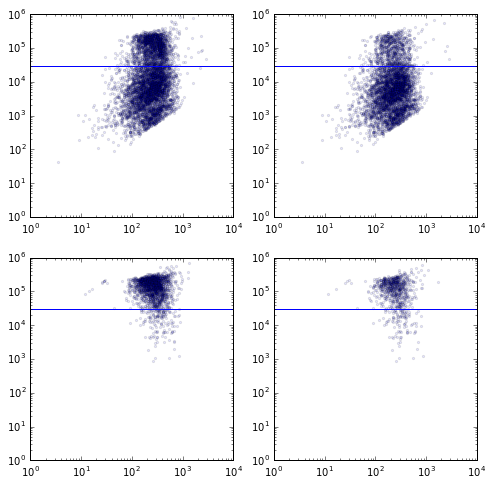

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ids_good_log_flat = np.where(TGAS_log_flat['P_posterior'] > 0.99)[0]
ax[0,0].scatter(dist_log_flat[ids_good_log_flat], s_log_flat[ids_good_log_flat], marker='.', alpha=0.1)

ids_good_power_law = np.where(TGAS_power_law['P_posterior'] > 0.99)[0]
ax[0,1].scatter(dist_power_law[ids_good_power_law], s_power_law[ids_good_power_law], marker='.', alpha=0.1)

ids_good_log_flat_false = np.where(TGAS_log_flat_false['P_posterior'] > 0.99)[0]
ax[1,0].scatter(dist_log_flat_false[ids_good_log_flat_false], s_log_flat_false[ids_good_log_flat_false], 
                marker='.', alpha=0.1)

ids_good_power_law_false = np.where(TGAS_power_law_false['P_posterior'] > 0.99)[0]
ax[1,1].scatter(dist_power_law_false[ids_good_power_law_false], s_power_law_false[ids_good_power_law_false], 
                marker='.', alpha=0.1)



for i in np.arange(2):
    for j in np.arange(2):
        ax[j,i].set_xlim(1.0, 1.0e4)
        ax[j,i].set_ylim(1.0, 1.0e6)

        ax[j,i].set_xscale('log')
        ax[j,i].set_yscale('log')

        ax[j,i].axhline(3.0e4)

    
plt.show()

In [49]:
ids_good_log_flat_wide = np.intersect1d(ids_good_log_flat, np.where(s_log_flat > 3.0e4)[0])
ids_good_power_law_wide = np.intersect1d(ids_good_power_law, np.where(s_power_law > 3.0e4)[0])

ids_good_log_flat_small = np.intersect1d(ids_good_log_flat, np.where(s_log_flat < 3.0e4)[0])
ids_good_power_law_small = np.intersect1d(ids_good_power_law, np.where(s_power_law < 3.0e4)[0])

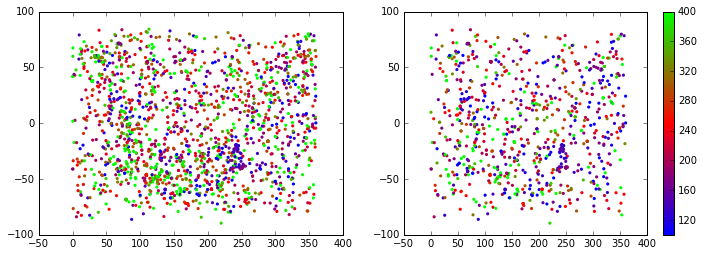

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

colors = dist_log_flat[ids_good_log_flat_wide]
colors[colors > 400.0] = 400.0
colors[colors < 100.0] = 100.0

ax[0].scatter(TGAS_log_flat[ids_good_log_flat_wide]['ra_1'], TGAS_log_flat[ids_good_log_flat_wide]['dec_1'], c=colors, edgecolor='none', cmap='brg', s=10)




colors = dist_power_law[ids_good_power_law_wide]
colors[colors > 400.0] = 400.0
colors[colors < 100.0] = 100.0

sc = ax[1].scatter(TGAS_power_law[ids_good_power_law_wide]['ra_1'], TGAS_power_law[ids_good_power_law_wide]['dec_1'], c=colors, edgecolor='none', cmap='brg', s=10)

fig.colorbar(sc)

plt.show()

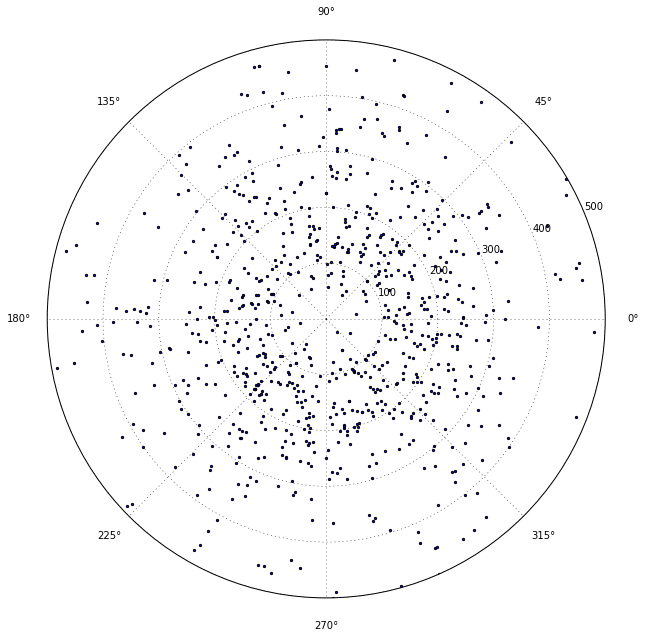

In [7]:
fig = plt.figure(figsize=(10, 10))

star1 = SkyCoord(TGAS_power_law[ids_good_power_law_wide]['ra_1'], TGAS_power_law[ids_good_power_law_wide]['dec_1'], unit='deg')
star2 = SkyCoord(TGAS_power_law[ids_good_power_law_wide]['ra_2'], TGAS_power_law[ids_good_power_law_wide]['dec_2'], unit='deg')

ax = plt.subplot(111, projection='polar')

ax.scatter(star1.galactic.l.deg, dist_power_law[ids_good_power_law_wide], marker='.')
ax.set_rmax(500.0)


plt.savefig("../figures/widest_power_law_galactic_distribution.pdf")
#plt.show()

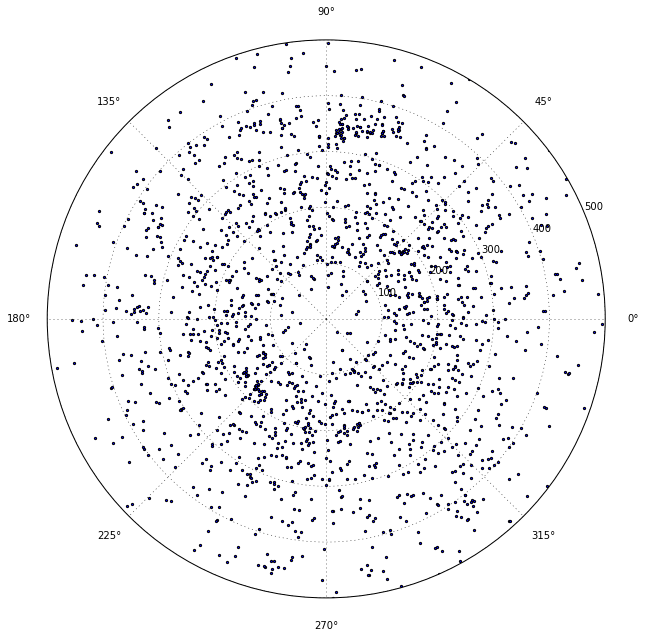

In [8]:
fig = plt.figure(figsize=(10, 10))

star1 = SkyCoord(TGAS_log_flat[ids_good_log_flat_wide]['ra_1'], TGAS_log_flat[ids_good_log_flat_wide]['dec_1'], unit='deg')
star2 = SkyCoord(TGAS_log_flat[ids_good_log_flat_wide]['ra_2'], TGAS_log_flat[ids_good_log_flat_wide]['dec_2'], unit='deg')

ax = plt.subplot(111, projection='polar')

ax.scatter(star1.galactic.l.deg, dist_log_flat[ids_good_log_flat_wide], marker='.')
ax.set_rmax(500.0)

plt.savefig("../figures/widest_log_flat_galactic_distribution.pdf")
#plt.show()

In [47]:
dtypes = [('source_ID_1','<f8'), 
          ('source_ID_2','<f8'),
          ('TYC_ID_1','S11'),
          ('TYC_ID_2','S11'),
          ('theta','<f8'),
          ('distance','<f8'),
          ('proj_sep','<f8')]

TGAS_log_flat_out = np.zeros(len(TGAS_log_flat), dtype=dtypes)

TGAS_log_flat_out['source_ID_1'] = TGAS_log_flat['source_ID_1']
TGAS_log_flat_out['source_ID_2'] = TGAS_log_flat['source_ID_2']
TGAS_log_flat_out['TYC_ID_1'] = TGAS_log_flat['TYC_ID_1']
TGAS_log_flat_out['TYC_ID_2'] = TGAS_log_flat['TYC_ID_2']
TGAS_log_flat_out['theta'] = TGAS_log_flat['theta']
TGAS_log_flat_out['distance'] = dist_log_flat
TGAS_log_flat_out['proj_sep'] = s_log_flat 

header = ''
for i in np.arange(len(TGAS_log_flat_out.dtype.names)):
    header = header + TGAS_log_flat_out.dtype.names[i] + ' '

fmt = '%i %i %s %s %.2f %f %f'
np.savetxt('../data/TGAS/dist_sep_log_flat.dat', TGAS_log_flat_out, delimiter=' ', fmt=fmt, header=header)

In [48]:
TGAS_power_law_out = np.zeros(len(TGAS_power_law), dtype=dtypes)

TGAS_power_law_out['source_ID_1'] = TGAS_power_law['source_ID_1']
TGAS_power_law_out['source_ID_2'] = TGAS_power_law['source_ID_2']
TGAS_power_law_out['TYC_ID_1'] = TGAS_power_law['TYC_ID_1']
TGAS_power_law_out['TYC_ID_2'] = TGAS_power_law['TYC_ID_2']
TGAS_power_law_out['theta'] = TGAS_power_law['theta']
TGAS_power_law_out['distance'] = dist_power_law
TGAS_power_law_out['proj_sep'] = s_power_law

header = ''
for i in np.arange(len(TGAS_log_flat_out.dtype.names)):
    header = header + TGAS_log_flat_out.dtype.names[i] + ' '

fmt = '%i %i %s %s %.2f %f %f'
np.savetxt('../data/TGAS/dist_sep_power_law.dat', TGAS_power_law_out, delimiter=' ', fmt=fmt, header=header)

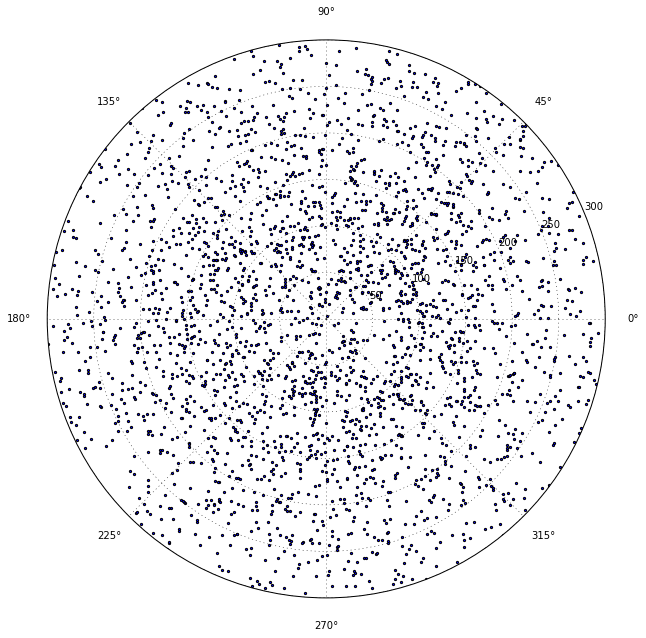

In [51]:
fig = plt.figure(figsize=(10, 10))

star1 = SkyCoord(TGAS_power_law[ids_good_power_law_small]['ra_1'], TGAS_power_law[ids_good_power_law_small]['dec_1'], unit='deg')
star2 = SkyCoord(TGAS_power_law[ids_good_power_law_small]['ra_2'], TGAS_power_law[ids_good_power_law_small]['dec_2'], unit='deg')

ax = plt.subplot(111, projection='polar')

ax.scatter(star1.galactic.l.deg, dist_power_law[ids_good_power_law_small], marker='.')
ax.set_rmax(300.0)


# plt.savefig("../figures/small_power_law_galactic_distribution.pdf")
plt.show()

In [52]:
print len(ids_good_power_law_small), len(ids_good_log_flat_small)

3876 4156
